In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss)
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0520/weights_KD_segformer_0520_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 1
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 7s 611ms/step - loss: 5.7534e-05
Average validation loss: 1.090139389038086
4/4 [==============================] - 7s 629ms/step - loss: 5.7534e-05 - val_loss: 1.0901
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 9s 621ms/step - loss: 5.4866e-05 - val_loss: 1.0901
Average validation loss: 0.3777724504470825
4/4 [==============================] - 9s 636ms/step - loss: 5.4866e-05 - val_loss: 0.7340
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 12s 721ms/step - loss: 5.3112e-05 - val_loss: 0.7340
Average validation loss: 0.7722192406654358
4/4 [==============================] - 12s 745ms/step - lo

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 751ms/step - loss: 1.2077e-04
Average validation loss: 1.4583078622817993
8/8 [==============================] - 6s 763ms/step - loss: 1.2077e-04 - val_loss: 1.4583
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 12s 722ms/step - loss: 1.1584e-04 - val_loss: 1.4583
Average validation loss: 0.16407234966754913
8/8 [==============================] - 12s 733ms/step - loss: 1.1584e-04 - val_loss: 0.8112
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 18s 704ms/step - loss: 1.1555e-04 - val_loss: 0.8112
Average validation loss: 0.3485131561756134
8/8 [==============================] - 18s 718ms/ste

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 735ms/step - loss: 1.2906e-04
Average validation loss: 0.2229622801144918
12/12 [==============================] - 9s 747ms/step - loss: 1.2906e-04 - val_loss: 0.2230
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 18s 726ms/step - loss: 1.2656e-04 - val_loss: 0.2230
Average validation loss: 0.03293055792649587
12/12 [==============================] - 18s 740ms/step - loss: 1.2656e-04 - val_loss: 0.1279
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 26s 703ms/step - loss: 1.2460e-04 - val_loss: 0.1279
Average validation loss: 0.07136089478929837
12/12 [==============================] - 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 11s 711ms/step - loss: 1.4069e-04
Average validation loss: 0.7574679851531982
16/16 [==============================] - 12s 723ms/step - loss: 1.4069e-04 - val_loss: 0.7575
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 712ms/step - loss: 1.2730e-04 - val_loss: 0.7575
Average validation loss: 0.16579093225300312
16/16 [==============================] - 23s 723ms/step - loss: 1.2730e-04 - val_loss: 0.4616
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 35s 717ms/step - loss: 1.2580e-04 - val_loss: 0.4616
Average validation loss: 0.1667647254653275
16/16 [==============================] -

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 716ms/step - loss: 1.0007e-04
Average validation loss: 2.368462610244751
20/20 [==============================] - 15s 728ms/step - loss: 1.0007e-04 - val_loss: 2.3685
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 708ms/step - loss: 9.9696e-05 - val_loss: 2.3685
Average validation loss: 0.6006958603858947
20/20 [==============================] - 29s 719ms/step - loss: 9.9696e-05 - val_loss: 1.4846
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 43s 715ms/step - loss: 9.5352e-05 - val_loss: 1.4846
Average validation loss: 2.51634259223938
20/20 [==============================] - 44s

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 719ms/step - loss: 8.2715e-05
Average validation loss: 1.049190620581309
24/24 [==============================] - 18s 730ms/step - loss: 8.2715e-05 - val_loss: 1.0492
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 710ms/step - loss: 7.5696e-05 - val_loss: 1.0492
Average validation loss: 0.8833814462025961
24/24 [==============================] - 35s 720ms/step - loss: 7.5696e-05 - val_loss: 0.9663
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 52s 708ms/step - loss: 7.2563e-05 - val_loss: 0.9663
Average validation loss: 0.7907347778479258
24/24 [==============================] - 5

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 29s 713ms/step - loss: 6.5976e-05
Average validation loss: 0.7111576199531555
40/40 [==============================] - 29s 725ms/step - loss: 6.5976e-05 - val_loss: 0.7112
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 57s 711ms/step - loss: 6.4469e-05 - val_loss: 0.7112
Average validation loss: 0.5348322719335556
40/40 [==============================] - 58s 723ms/step - loss: 6.4469e-05 - val_loss: 0.6230
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 87s 715ms/step - loss: 6.1747e-05 - val_loss: 0.6230
Average validation loss: 0.46078679859638216
40/40 [==============================] -

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 34s 716ms/step - loss: 4.6936e-05
Average validation loss: 1.868323306242625
48/48 [==============================] - 35s 728ms/step - loss: 4.6936e-05 - val_loss: 1.8683
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 70s 720ms/step - loss: 5.1497e-05 - val_loss: 1.8683
Average validation loss: 0.7846949348847071
48/48 [==============================] - 70s 731ms/step - loss: 5.1497e-05 - val_loss: 1.3265
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 104s 710ms/step - loss: 4.6777e-05 - val_loss: 1.3265
Average validation loss: 0.7828722844521204
48/48 [==============================] - 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 40s 715ms/step - loss: 3.2874e-05
Average validation loss: 1.1722745639937264
56/56 [==============================] - 41s 727ms/step - loss: 3.2874e-05 - val_loss: 1.1723
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 81s 716ms/step - loss: 3.0310e-05 - val_loss: 1.1723
Average validation loss: 1.3369999996253423
56/56 [==============================] - 82s 728ms/step - loss: 3.0310e-05 - val_loss: 1.2546
Epoch 3/10
56/56 [==============================] - 122s 713ms/step - loss: 2.9650e-05 - val_loss: 1.2546
Average validation loss: 1.0875456290585654
56/56 [==============================] - 122s 725ms/step - loss: 2.9650e-05 - val_loss: 1.1989
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weig

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 45s 711ms/step - loss: 3.7357e-05
Average validation loss: 1.2267516180872917
64/64 [==============================] - 46s 722ms/step - loss: 3.7357e-05 - val_loss: 1.2268
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 92s 715ms/step - loss: 3.3232e-05 - val_loss: 1.2268
Average validation loss: 1.3898561522364616
64/64 [==============================] - 93s 727ms/step - loss: 3.3232e-05 - val_loss: 1.3083
Epoch 3/10
64/64 [==============================] - 138s 710ms/step - loss: 3.0880e-05 - val_loss: 1.3083
Average validation loss: 1.7422736510634422
64/64 [==============================] - 139s 721ms/step - loss: 3.0880e-05 - val_loss: 1.4530
Epoch 4/10
64/64 [==============================] - 185s 714ms/step - loss: 3.0050e-05 - val_loss: 1.4530
Average validati

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 52s 716ms/step - loss: 2.7675e-05
Average validation loss: 0.9790261586507162
72/72 [==============================] - 52s 728ms/step - loss: 2.7675e-05 - val_loss: 0.9790
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 104s 714ms/step - loss: 2.8098e-05 - val_loss: 0.9790
Average validation loss: 1.577537390920851
72/72 [==============================] - 105s 725ms/step - loss: 2.8098e-05 - val_loss: 1.2783
Epoch 3/10
72/72 [==============================] - 157s 721ms/step - loss: 2.7539e-05 - val_loss: 1.2783
Average validation loss: 1.4043378432591755
72/72 [==============================] - 157s 733ms/step - loss: 2.7539e-05 - val_loss: 1.3203
Epoch 4/10
72/72 [==============================] - 209s 713ms/step - loss: 2.6212e-05 - val_loss: 1.3203
Average validat

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 57s 713ms/step - loss: 2.9814e-05
Average validation loss: 1.191387790441513
80/80 [==============================] - 58s 725ms/step - loss: 2.9814e-05 - val_loss: 1.1914
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 116s 719ms/step - loss: 2.7578e-05 - val_loss: 1.1914
Average validation loss: 1.1322190165519714
80/80 [==============================] - 117s 730ms/step - loss: 2.7578e-05 - val_loss: 1.1618
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 174s 715ms/step - loss: 2.5628e-05 - val_loss: 1.1618
Average validation loss: 1.2356480181217193
80/80 [==============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 69s 715ms/step - loss: 2.9650e-05
Average validation loss: 1.1732634454965591
96/96 [==============================] - 70s 727ms/step - loss: 2.9650e-05 - val_loss: 1.1733
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 138s 712ms/step - loss: 2.6850e-05 - val_loss: 1.1733
Average validation loss: 1.2341713880499203
96/96 [==============================] - 139s 723ms/step - loss: 2.6850e-05 - val_loss: 1.2037
Epoch 3/10
96/96 [==============================] - 208s 712ms/step - loss: 2.5042e-05 - val_loss: 1.2037
Average validation loss: 1.1119954784711201
96/96 [==============================] - 209s 724ms/step - loss: 2.5042e-05 - val_loss: 1.1731
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/w

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 85s 712ms/step - loss: 4.1390e-05
Average validation loss: 1.1198734442392986
120/120 [==============================] - 87s 724ms/step - loss: 4.1390e-05 - val_loss: 1.1199
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 172s 711ms/step - loss: 3.8571e-05 - val_loss: 1.1199
Average validation loss: 1.2491535623868306
120/120 [==============================] - 174s 722ms/step - loss: 3.8571e-05 - val_loss: 1.1845
Epoch 3/10
120/120 [==============================] - 259s 714ms/step - loss: 3.6859e-05 - val_loss: 1.1845
Average validation loss: 1.061357076962789
120/120 [==============================] - 261s 726ms/step - loss: 3.6859e-05 - val_loss: 1.1435
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segfo

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 113s 784ms/step - loss: 4.2667e-05
Average validation loss: 1.02316133512391
144/144 [==============================] - 115s 796ms/step - loss: 4.2667e-05 - val_loss: 1.0232
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 228s 784ms/step - loss: 3.9906e-05 - val_loss: 1.0232
Average validation loss: 1.2990071343051062
144/144 [==============================] - 229s 795ms/step - loss: 3.9906e-05 - val_loss: 1.1611
Epoch 3/10
144/144 [==============================] - 334s 725ms/step - loss: 3.6917e-05 - val_loss: 1.1611
Average validation loss: 0.7744800729884042
144/144 [==============================] - 336s 737ms/step - loss: 3.6917e-05 - val_loss: 1.0322
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segf

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 115s 716ms/step - loss: 3.5743e-05
Average validation loss: 1.1524129658937454
160/160 [==============================] - 117s 728ms/step - loss: 3.5743e-05 - val_loss: 1.1524
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 231s 715ms/step - loss: 3.3577e-05 - val_loss: 1.1524
Average validation loss: 0.9686356112360954
160/160 [==============================] - 233s 727ms/step - loss: 3.3577e-05 - val_loss: 1.0605
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 347s 713ms/step - loss: 3.1634e-05 - val_loss: 1.0605
Average validation loss: 1.2493820920586587
160/160 [===============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 143s 713ms/step - loss: 4.0219e-05
Average validation loss: 0.848265095949173
200/200 [==============================] - 145s 725ms/step - loss: 4.0219e-05 - val_loss: 0.8483
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 288s 714ms/step - loss: 3.6580e-05 - val_loss: 0.8483
Average validation loss: 1.1289231336116792
200/200 [==============================] - 290s 726ms/step - loss: 3.6580e-05 - val_loss: 0.9886
Epoch 3/10
200/200 [==============================] - 432s 711ms/step - loss: 3.4341e-05 - val_loss: 0.9886
Average validation loss: 0.9106022465229034
200/200 [==============================] - 435s 722ms/step - loss: 3.4341e-05 - val_loss: 0.9626
Epoch 4/10
200/200 [==============================] - 577s 711ms/step - loss: 3.2721e-05 - val_loss: 0.962

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:46 - loss: 5.2164e-05

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 171s 712ms/step - loss: 4.1113e-05
Average validation loss: 0.7513956626256307
240/240 [==============================] - 174s 724ms/step - loss: 4.1113e-05 - val_loss: 0.7514
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_100\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 345s 714ms/step - loss: 3.5699e-05 - val_loss: 0.7514
Average validation loss: 0.7544060031572978
240/240 [==============================] - 348s 726ms/step - loss: 3.5699e-05 - val_loss: 0.7529
Epoch 3/10
240/240 [==============================] - 519s 712ms/step - loss: 3.3093e-05 - val_loss: 0.7529
Average validation loss: 0.8963741391897202
240/240 [==============================] - 522s 723ms/step - loss: 3.3093e-05 - val_loss: 0.8007
Epoch 4/10
240/240 [==============================] - 693s 712ms/step - loss: 3.1018e-05 - val_loss: 0.80

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.6353235721588135, 0.47514352346770466, 0.5420419599922995, 0.7747265532614017, 0.7282318439477823, 0.6352412946301047, 0.8271426044553519, 1.1767180682718754, 1.3232516051190237, 1.3155820371955633, 1.338507880502277, 1.2976422501206397, 1.2600574436783791, 1.172675060391426, 1.1056590226954883, 1.0631911424696447, 0.9706108205676078, 0.834767001107335]
std_val_losses =  [0.3993624532961906, 0.470639917235576, 0.4801551650667045, 0.6250391802386376, 0.5022582029762352, 0.3365443215106044, 0.21600670112631026, 0.3481026286449541, 0.19639673304225427, 0.19606817004529042, 0.16390845379651264, 0.14982055560938787, 0.13102773280976268, 0.14609744800272573, 0.13883740346173398, 0.14163115263761708, 0.10289316639745996, 0.08642618779524118]


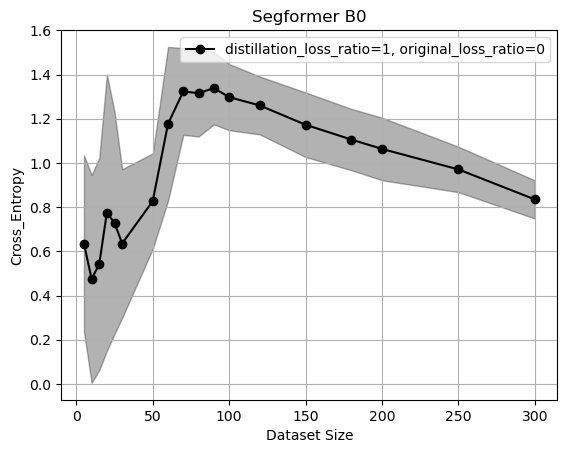

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0520')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.png"))

plt.show()